<h1><center>LINMA2472 : Project 2 - part 2, Random Fourier Features </center></h1>

$\textbf{Author}$: Remi Delogne, remi.delogne@uclouvain.be

Import the following packages and functions. Refer to their documentation on the internet for more information on installation and usage.

In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import accuracy_score

from keras.datasets import mnist #Contains the dataset
from matplotlib import pyplot

import time #Used to find the execution time of a part of the code

from IPython.display import display, HTML #For visual comfort
display(HTML("<style>.container { width:80% !important; }</style>"))

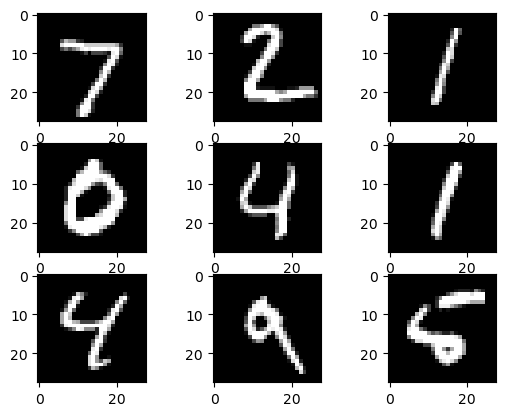

(10000, 784)


In [2]:
# load dataset and rescale the data to [0,15]
''' load dataset: (we use the larger subset for testing and the smaller 
for training to demonstrate the efficiency of evaluating of new instances with RFF)'''
(testX,testy),(trainX,trainy) = mnist.load_data()
#Rescaling
trainX = np.floor(trainX/16)
testX = np.floor(testX/16)

#Plot some images, for fun
for i in range(9):
    pyplot.subplot(330+1+i)
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

#Put the data in vector form
trainX=trainX.reshape((10000,-1))
testX=testX.reshape((60000,-1))
print(trainX.shape)

### Use the *time* package functions to time the executions of parts of your code:

In [3]:
#Example of timing a piece of code
tik=time.perf_counter() # Start
for i in range (1000000):
    i=i+1
tok=time.perf_counter() # Finish
print(f'Total time: {tok-tik:.3f} seconds')#prints the result to 3 decimal places

Total time: 0.150 seconds


### Train a linear SVM on the training data and evaluate it on the testing data
Use the tik-tok method to see how long the classifier takes to evaluate the 60.000 testing instances.

Use the accuracy metric to judge the quality of your classifier.

In [4]:
#Define the classifier
clfLin=svm.SVC(kernel="linear")

#Train the classifier
tik = time.perf_counter() # Start measuring training time
clfLin.fit(trainX,trainy)
tok = time.perf_counter() # Stop measuring training time
linear_training_time = tok - tik

#Evaluate its accuracy
tik = time.perf_counter()
predicted=clfLin.predict(testX)
score_linear=accuracy_score(testy,predicted)
tok = time.perf_counter()
linear_testing_time = tok - tik

print(f"Training finished in {linear_training_time:.3f} seconds,")
print(f"Testing Finished in {linear_testing_time:.3f} seconds with accuracy of {score_linear:.3f}.")

Training finished in 8.091 seconds,
Testing Finished in 56.024 seconds with accuracy of 0.907.


### Train a Kernel SVM with the Gaussian Kernel on the training data and evaluate it on the testing data
Use the tik-tok method to see how long the classifier takes to evaluate the $60000$ testing instances.

Use the accuracy metric to judge the quality of your classifier.

You may stick to the default parameters of sci-kit learn.

In [5]:
#Define the classifier
clfKernel=svm.SVC(kernel='rbf')
#Train it
tik = time.perf_counter()
clfKernel.fit(trainX, trainy)
tok = time.perf_counter()
rbf_training_time = tok - tik

#Use it
tik = time.perf_counter()
predicted=clfKernel.predict(testX)
score_rbf=accuracy_score(testy,predicted)
tok = time.perf_counter()
rbf_testing_time = tok - tik

print(f"Training finished in {rbf_training_time:.3f} seconds,")
print(f"Testing Finished in {rbf_testing_time:.3f} seconds with accuracy of {score_rbf:.3f}.")

Training finished in 13.696 seconds,
Testing Finished in 146.925 seconds with accuracy of 0.956.


### *TO DO*: Use the following functions to implement Random Fourier Features

You are here going to try to approximate the Gaussian kernel used in the second classfier.

Use the first function to generate your $\boldsymbol\omega_i$ (using an appropriate distribution) and your $b_i$ (using appropriate distributions), this should return $D$ vectors $\boldsymbol\omega_i\in\mathbb R^d$ (in the form of a matrix for example) and $D$ values $b_i\in[0,2\pi]$. 

Use the second function to create the mapping $\boldsymbol z(\boldsymbol x)$ as described in the slides.

In [6]:
def generate_freq(D, d, sigma):

  W = np.zeros((D, d))
  b = np.zeros(D)

  for i in range(D):
    W[i] = np.random.normal(scale = sigma, size = d)
    b[i] = np.random.uniform(0, 2 * np.pi)

  return W,b

def transform(X, W, D, b):
   # la formule c'est z = sqrt(2/D) * cos(w'x + b) avec Z matrice de (shape(x),D)
  N = X.shape[0]
  Z = np.zeros((N, D))

  for i in range(N):
    for j in range(D):
      temp = np.dot(W[j],X[i]) + b[j]
      temp = np.cos(temp)
      Z[i][j] = np.sqrt(2/D) * temp

  return Z

### *TO DO*: Transform your trainX and testX

Use the function you defined to transform your data.

Make sure you only generate $\boldsymbol W$ and $\boldsymbol b$ once.

Use a standard deviation of $\frac{1}{100}$ et $D=300$ random features to start with. Watch out, in the original version of the homework it was specified that the variance was $\frac{1}{100}$ but it must be the standard deviation instead.

You may also use the tik-tok method to time the procedure of creating Random features.

In [7]:
D=300 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

tik = time.perf_counter()
W,b=generate_freq(D, d, sigma)
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

RFF transformation time : 111.327 seconds.


In [8]:
#Sanity check, do the dimensions of your transformations match your expectation?
#Bear in mind that there are more instances in the test set than in the trianing set here
print(f"Dimension of trainX after transformation : {trainX_rff.shape}.")
print(f"Dimension of testX after transformation : {testX_rff.shape}.")

Dimension of trainX after transformation : (10000, 300).
Dimension of testX after transformation : (60000, 300).


### Use another linear SVM to classify the transformed data
Now that the instances have been transformed, theory tells us that they are much more ameneable to linear classification than before.

In [9]:
#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1e10)

#Train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#Use it
tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

Training Finished in 5.100 seconds
Testing Finished in 32.113 seconds with accuracy of 0.893


In [10]:
D=200 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

RFF transformation time : 75.755 seconds.


In [11]:
#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1e10)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

Training Finished in 6.768 seconds


In [12]:
#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

Testing Finished in 19.970 seconds with accuracy of 0.857


In [13]:
D=10 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 3.962 seconds.
Training Finished in 4.047 seconds
Testing Finished in 22.578 seconds with accuracy of 0.443


In [14]:
D=100 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 38.964 seconds.
Training Finished in 2.902 seconds
Testing Finished in 23.699 seconds with accuracy of 0.839


In [15]:
D=400 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 156.146 seconds.
Training Finished in 8.795 seconds
Testing Finished in 50.432 seconds with accuracy of 0.923


In [16]:
D=500 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 195.397 seconds.
Training Finished in 9.540 seconds
Testing Finished in 59.574 seconds with accuracy of 0.932


In [17]:
D=650 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 255.678 seconds.
Training Finished in 11.471 seconds
Testing Finished in 73.229 seconds with accuracy of 0.937


In [18]:
D=750 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 294.865 seconds.
Training Finished in 12.553 seconds
Testing Finished in 84.567 seconds with accuracy of 0.939


In [19]:
D=850 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 333.996 seconds.
Training Finished in 13.361 seconds
Testing Finished in 91.313 seconds with accuracy of 0.940


In [20]:
D=900 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 351.484 seconds.
Training Finished in 14.460 seconds
Testing Finished in 101.042 seconds with accuracy of 0.941


In [21]:
D=1000 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 395.014 seconds.
Training Finished in 15.043 seconds
Testing Finished in 106.638 seconds with accuracy of 0.942


In [22]:
D=50 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 19.233 seconds.
Training Finished in 2.226 seconds
Testing Finished in 15.278 seconds with accuracy of 0.743


In [23]:
D=200 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 77.011 seconds.
Training Finished in 4.873 seconds
Testing Finished in 29.250 seconds with accuracy of 0.905


In [24]:
D=300 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 115.884 seconds.
Training Finished in 7.585 seconds
Testing Finished in 44.864 seconds with accuracy of 0.920


In [25]:
D=950 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 375.746 seconds.
Training Finished in 15.166 seconds
Testing Finished in 104.122 seconds with accuracy of 0.942


In [27]:
D=25 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 11.609 seconds.
Training Finished in 2.954 seconds
Testing Finished in 18.112 seconds with accuracy of 0.583


In [30]:
D=15 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 7.873 seconds.
Training Finished in 3.714 seconds
Testing Finished in 20.328 seconds with accuracy of 0.502


In [31]:
D=20 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 7.637 seconds.
Training Finished in 2.809 seconds
Testing Finished in 17.429 seconds with accuracy of 0.580


In [32]:
D=30 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 12.015 seconds.
Training Finished in 3.266 seconds
Testing Finished in 18.077 seconds with accuracy of 0.586


In [33]:
D=35 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 13.326 seconds.
Training Finished in 2.564 seconds
Testing Finished in 16.769 seconds with accuracy of 0.694


In [34]:
D=40 #Number of sample vectors w_i
sigma=0.01 #Variance of distributon
d=28*28 #Original number of dimensions

W,b=generate_freq(D, d, sigma)
tik = time.perf_counter()
trainX_rff=transform(trainX, W, D, b)
testX_rff=transform(testX, W, D, b)
tok = time.perf_counter()
rff_time = tok - tik
print(f"RFF transformation time : {rff_time:.3f} seconds.")

#Define the classifier
clfRff = svm.SVC(kernel="linear",C=1)

#train it
tik = time.perf_counter()
clfRff.fit(trainX_rff, trainy)
tok = time.perf_counter()
training_time_rff = tok - tik
print(f"Training Finished in {training_time_rff:.3f} seconds")

#test it

tik = time.perf_counter()
predicted = clfRff.predict(testX_rff)
score_rff = accuracy_score(testy,predicted)
tok = time.perf_counter()
testing_time_rff = tok - tik
print(f"Testing Finished in {testing_time_rff:.3f} seconds with accuracy of {score_rff:.3f}")

RFF transformation time : 15.159 seconds.
Training Finished in 2.138 seconds
Testing Finished in 14.420 seconds with accuracy of 0.728


C = 1

10 : 
RFF transformation time : 3.962 seconds.
Training Finished in 4.047 seconds
Testing Finished in 22.578 seconds with accuracy of 0.4

25 :
RFF transformation time : 11.609 seconds.
Training Finished in 2.954 seconds
Testing Finished in 18.112 seconds with accuracy of 0.583

50 :

RFF transformation time : 19.233 seconds.
Training Finished in 2.226 seconds
Testing Finished in 15.278 seconds with accuracy of 0.743

100 :
RFF transformation time : 38.964 seconds.
Training Finished in 2.902 seconds
Testing Finished in 23.699 seconds with accuracy of 0

200 :
RFF transformation time : 77.011 seconds.
Training Finished in 4.873 seconds
Testing Finished in 29.250 seconds with accuracy of 0.9

300 :
RFF transformation time : 115.884 seconds.
Training Finished in 7.585 seconds
Testing Finished in 44.864 seconds with accuracy of 0.92005.83
400:
RFF transformation time : 156.146 seconds.
Training Finished in 8.795 seconds
Testing Finished in 50.432 seconds with accuracy of 0.9

500 :
RFF transformation time : 195.397 seconds.
Training Finished in 9.540 seconds
Testing Finished in 59.574 seconds with accuracy of 0.9

650 :
RFF transformation time : 255.678 seconds.
Training Finished in 11.471 seconds
Testing Finished in 73.229 seconds with accuracy of 0.9

750 :
RFF transformation time : 294.865 seconds.
Training Finished in 12.553 seconds
Testing Finished in 84.567 seconds with accuracy of 0.9

850 :
RFF transformation time : 333.996 seconds.
Training Finished in 13.361 seconds
Testing Finished in 91.313 seconds with accuracy of 0.9

900 :
RFF transformation time : 351.484 seconds.
Training Finished in 14.460 seconds
Testing Finished in 101.042 seconds with accuracy 

950 :
RFF transformation time : 375.746 seconds.
Training Finished in 15.166 seconds
Testing Finished in 104.122 seconds with accuracy of 0.942of 0.9

1000 :
RFF transformation time : 395.014 seconds.
Training Finished in 15.043 seconds
Testing Finished in 106.638 seconds with accuracy of 0.942414039373223943


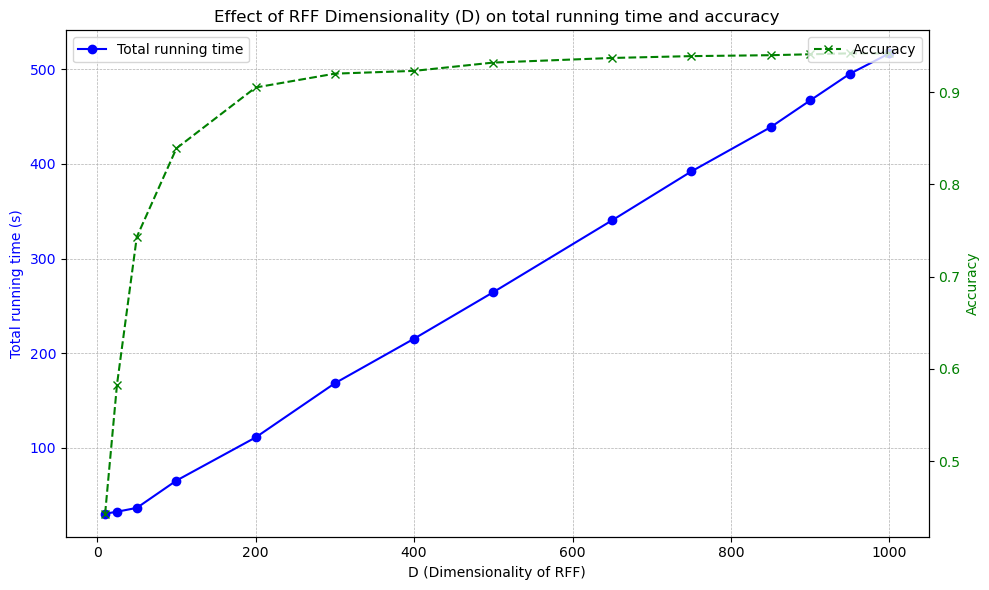

In [39]:
import matplotlib.pyplot as plt

D_values = [10, 25, 50, 100, 200, 300, 400, 500, 650, 750, 850, 900, 950, 1000]
rff_times = [3.962, 11.609, 19.233, 38.964, 77.011, 115.884, 156.146, 195.397, 255.678, 294.865, 333.996, 351.484, 375.746, 395.014]
train_times = [4.047, 2.954, 2.226, 2.902, 4.873, 7.585, 8.795, 9.54, 11.471, 12.553, 13.361, 14.46, 15.166, 15.043]
test_times = [22.578, 18.112, 15.278, 23.699, 29.25, 44.864, 50.432, 59.574, 73.229, 84.567, 91.313, 101.042, 104.122, 106.638]
accuracy = [0.443, 0.583, 0.743, 0.839, 0.905, 0.92, 0.923, 0.932, 0.937, 0.939, 0.94, 0.941, 0.942, 0.942]
total_times = [rff + train + test for rff, train, test in zip(rff_times, train_times, test_times)]

fig, ax1 = plt.subplots(figsize=(10, 6))

#Standard y
ax1.plot(D_values, total_times, label="Total running time", color="blue", marker="o", linestyle="-")
ax1.set_xlabel("D (Dimensionality of RFF)")
ax1.set_ylabel("Total running time (s)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
#Second y-axis
ax2 = ax1.twinx()
ax2.plot(D_values, accuracy, label="Accuracy", color="green", marker="x", linestyle="--")
ax2.set_ylabel("Accuracy", color="green")
ax2.tick_params(axis='y', labelcolor="green")

plt.title("Effect of RFF Dimensionality (D) on total running time and accuracy")
ax1.grid(visible=True, which="both", linestyle="--", linewidth=0.5)


ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()

plt.savefig("total_runtime.pdf", format="pdf")

plt.show()


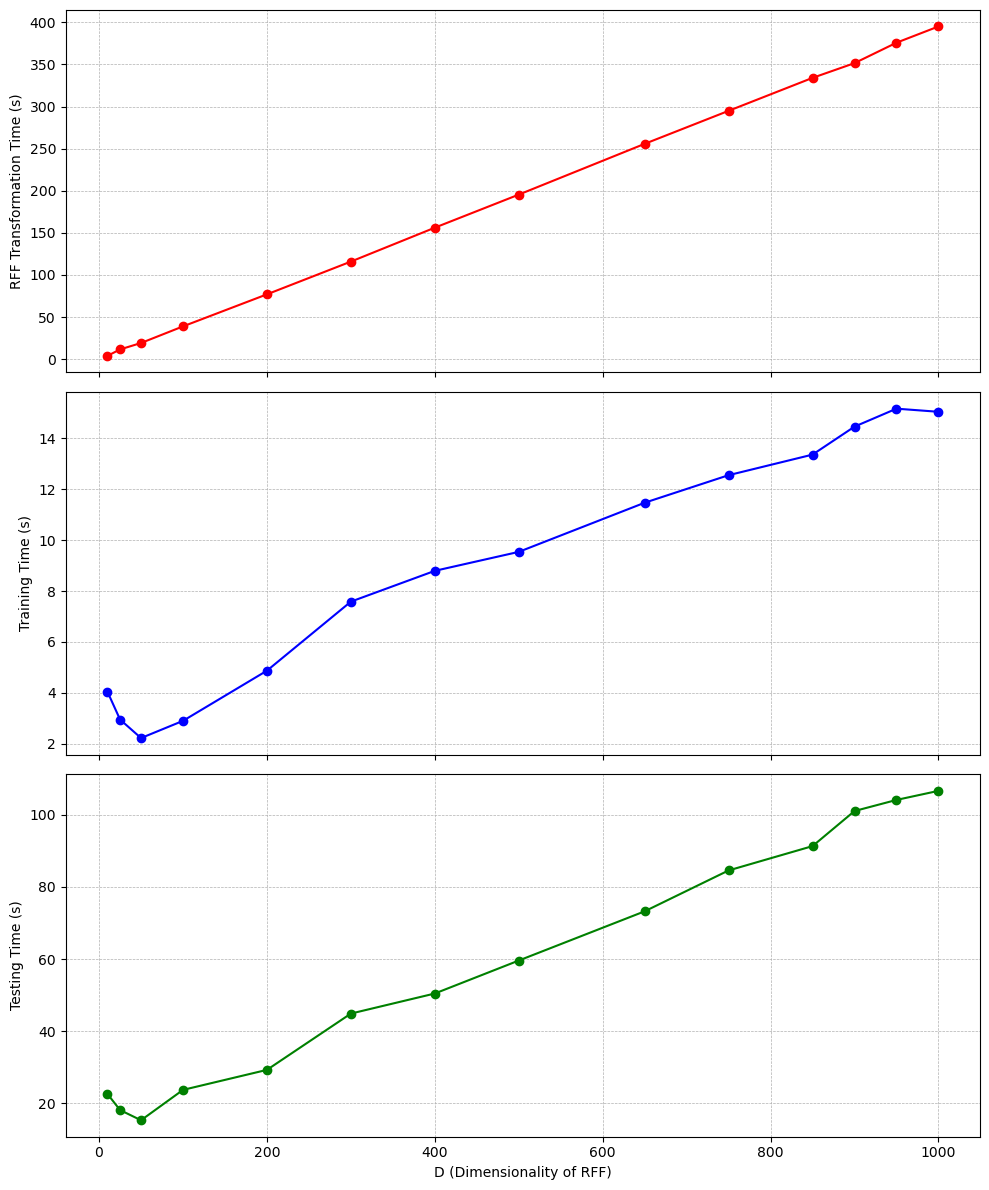

In [43]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

#rff
axes[0].plot(D_values, rff_times, marker="o", color="red", linestyle="-")
axes[0].set_ylabel("RFF Transformation Time (s)")
axes[0].grid(visible=True, linestyle="--", linewidth=0.5)
axes[0].tick_params(axis='y')

#train
axes[1].plot(D_values, train_times, marker="o", color="blue", linestyle="-")
axes[1].set_ylabel("Training Time (s)")
axes[1].grid(visible=True, linestyle="--", linewidth=0.5)
axes[1].tick_params(axis='y')

#test
axes[2].plot(D_values, test_times, marker="o", color="green", linestyle="-")
axes[2].set_ylabel("Testing Time (s)")
axes[2].set_xlabel("D (Dimensionality of RFF)")
axes[2].grid(visible=True, linestyle="--", linewidth=0.5)
axes[2].tick_params(axis='y')

plt.tight_layout()

plt.savefig("triple_plot.pdf", format="pdf")

plt.show()


For D = 30 : 
RFF transformation time : 12.015 seconds.
Training Finished in 3.266 seconds
Testing Finished in 18.077 seconds with accuracy of 0.586. 
For D = 35 : 
RFF transformation time : 13.326 seconds.
Training Finished in 2.564 seconds
Testing Finished in 16.769 seconds with accuracy of 0.694. 
For D = 40 : 
RFF transformation time : 15.159 seconds.
Training Finished in 2.138 seconds
Testing Finished in 14.420 seconds with accuracy of 0.728

In [37]:
D = [10, 15, 20, 25, 30, 35, 40, 50, 100, 200]#, 300, 400, 500, 650, 750, 850, 900, 950, 1000]
rff = [3.962, 7.873, 7.637, 11.609, 12.015, 13.326, 15.159, 19.233, 38.964, 77.011]#, 115.884, 156.146, 195.397, 255.678, 294.865, 333.996, 351.484, 375.746, 395.014]
train = [4.047, 3.714, 2.809, 2.954, 3.266, 2.564, 2.138, 2.226, 2.902, 4.873]#, 7.585, 8.795, 9.54, 11.471, 12.553, 13.361, 14.46, 15.166, 15.043]
test = [22.578, 20.238, 17.429, 18.112, 18.077, 16.769, 14.420, 15.278, 23.699, 29.25]#, 44.864, 50.432, 59.574, 73.229, 84.567, 91.313, 101.042, 104.122, 106.638]
acc = [0.443, 0.502, 0.580, 0.583, 0.586, 0.694, 0.728, 0.743, 0.839, 0.905]#, 0.92, 0.923, 0.932, 0.937, 0.939, 0.94, 0.941, 0.942, 0.942]

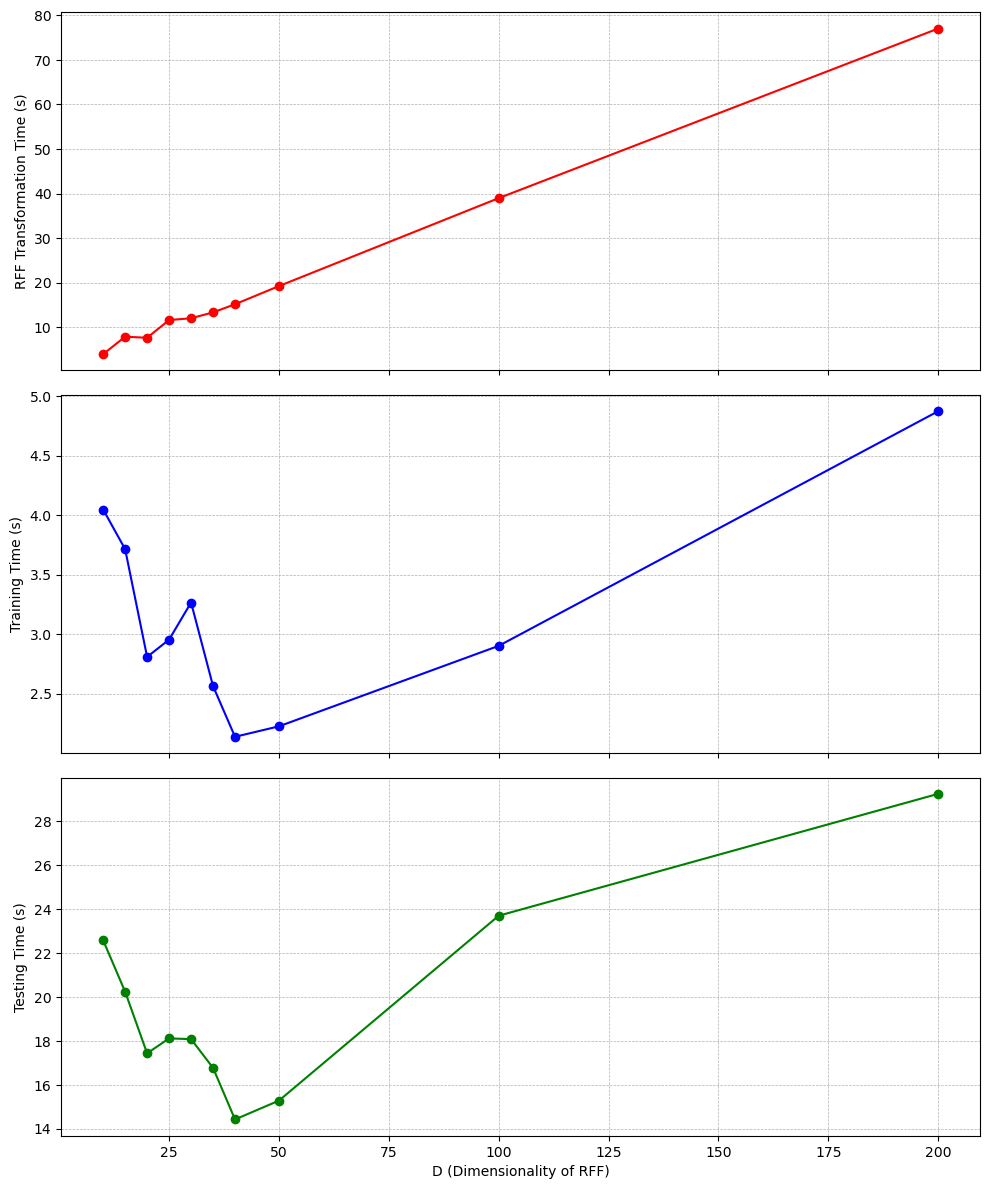

In [44]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

#rff
axes[0].plot(D, rff, marker="o", color="red", linestyle="-")
axes[0].set_ylabel("RFF Transformation Time (s)")
axes[0].grid(visible=True, linestyle="--", linewidth=0.5)
axes[0].tick_params(axis='y')

#train
axes[1].plot(D, train, marker="o", color="blue", linestyle="-")
axes[1].set_ylabel("Training Time (s)")
axes[1].grid(visible=True, linestyle="--", linewidth=0.5)
axes[1].tick_params(axis='y')

#test
axes[2].plot(D, test, marker="o", color="green", linestyle="-")
axes[2].set_ylabel("Testing Time (s)")
axes[2].set_xlabel("D (Dimensionality of RFF)")
axes[2].grid(visible=True, linestyle="--", linewidth=0.5)
axes[2].tick_params(axis='y')

plt.tight_layout()

plt.savefig("triple_plot_more_data.pdf", format="pdf")

plt.show()

300 :
RFF transformation time : 116.899 seconds.
Training Finished in 5.861 seconds
Testing Finished in 32.937 seconds with accuracy of 0.89

200 :
RFF transformation time : 75.467 seconds.
Training Finished in 5.964 seconds
Testing Finished in 19.771 seconds with accuracy of 0.864

250 :
RFF transformation time : 96.498 seconds.
Training Finished in 5.347 seconds
Testing Finished in 25.225 seconds with accuracy of 0.8

500 :
RFF transformation time : 199.871 seconds.
Training Finished in 7.604 seconds
Testing Finished in 48.715 seconds with accuracy of 0.9

750 :
RFF transformation time : 297.933 seconds.
Training Finished in 10.178 seconds
Testing Finished in 75.523 seconds with accuracy of 0.9

1000:
RFF transformation time : 399.197 seconds.
Training Finished in 13.058 seconds
Testing Finished in 99.936 seconds with accuracy of 0.9413621815

### Additional workspace 
Investigate the relationship between $D$ and the accuracy of the classifier.

In [ ]:
#Define a vector to store the accuracy values you will get
accuracy=np.zeros()
#Define for which values of D you want to test the RFF
#maybe time some operations in the loop as well to see the RFF classifier becomes too slow as D grows
for i in (...):
    D=...
    trainX_rff=...
    testX_rff=...
    
    #Train and evaluate a linear classifier
    
    acc=...
    accuracy[i]=acc

### Don't forget to add plots and other nice things

Top-tip: add your figures saved as pdf for better reports !